## CNN Model for Weight Allocation & Sharp Ratio (Pre-Dimensionality Reduction)

In [59]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Data Loading and Preparation ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5d-standardized_dataset.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG','SPY','USO','VNQ','VXUS']
features = ['returns','RSI_14','MACD']
lookback = 20

X_list, y_list, dates_list = [], [], []
for i in range(lookback, len(data)):
    cur_date = data.iloc[i]['Date']
    day_slice = data[data['Date'] == cur_date]
    if set(assets) <= set(day_slice['Ticker']):
        X_i = []
        for asset in assets:
            asset_slice = data[(data['Ticker'] == asset) & (data['Date'] <= cur_date)].tail(lookback)
            if len(asset_slice) == lookback:
                X_i.extend(asset_slice[features].values.flatten())
            else:
                break
        else:
            next_idx = i + 1
            if next_idx < len(data):
                next_date = data.iloc[next_idx]['Date']
                next_day_slice = data[data['Date'] == next_date]
                if set(assets) <= set(next_day_slice['Ticker']):
                    y_i = next_day_slice.set_index('Ticker').loc[assets]['returns'].values
                    X_list.append(np.array(X_i))
                    y_list.append(y_i)
                    dates_list.append(cur_date)

X = np.array(X_list)
y = np.array(y_list)
dates = np.array(dates_list)

split_date = pd.to_datetime('2023-01-01')
train_mask = dates < split_date
test_mask = dates >= split_date

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]
dates_test = dates[test_mask]

n_assets = len(assets)
n_features = len(features)
X_train_t = torch.tensor(X_train, dtype=torch.float32).reshape(-1, lookback, n_assets * n_features)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32).reshape(-1, lookback, n_assets * n_features)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# --- 2. Model Definition ---
class PortfolioCNN(nn.Module):
    def __init__(self, lookback, n_assets, n_features, out_channels=8, kernel_size=3, temperature=3.0):
        super().__init__()
        self.temperature = temperature
        self.conv = nn.Conv2d(1, out_channels, (kernel_size, 1), padding=(kernel_size // 2, 0))
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, lookback, n_assets * n_features)
            dummy_out = self.conv(dummy_input)
            flattened_size = dummy_out.numel()

        self.fc = nn.Linear(flattened_size, n_assets)

    def forward(self, x):
        x = x.unsqueeze(1)
        out = self.relu(self.conv(x))
        out = self.flatten(out)
        out = self.fc(out)
        weights = torch.softmax(out / self.temperature, dim=-1)
        return weights

def compute_portfolio_returns(weights, y_true):
    return torch.sum(weights * y_true, dim=1)

def sharpe_loss(returns):
    return -torch.mean(returns) / (torch.std(returns) + 1e-9)

def entropy_regularization(weights, lambda_entropy=0.1):
    entropy = -torch.sum(weights * torch.log(weights + 1e-8), dim=1)
    return -lambda_entropy * torch.mean(entropy)

def l2_regularization(model, lambda_l2=1e-4):
    return lambda_l2 * sum((param ** 2).sum() for param in model.parameters())

# --- 3. Training ---
def train_model(model, X_train, y_train, optimizer, num_epochs= 50, batch_size=32):
    model.train()
    n = len(X_train)
    metrics = {'epoch_time': [], 'sharpe': [], 'mse': []}
    for epoch in range(num_epochs):
        start_time = time.time()
        perm = torch.randperm(n)
        epoch_sharpe, epoch_mse = 0, 0
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            batch_X, batch_y = X_train[idx], y_train[idx]
            weights = model(batch_X)
            port_returns = compute_portfolio_returns(weights, batch_y)
            loss = sharpe_loss(port_returns) + entropy_regularization(weights) + l2_regularization(model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_sharpe += -sharpe_loss(port_returns).item()
            epoch_mse += nn.MSELoss()(port_returns, batch_y.mean(dim=1)).item()
        elapsed = time.time() - start_time
        metrics['epoch_time'].append(elapsed)
        metrics['sharpe'].append(epoch_sharpe / (n // batch_size))
        metrics['mse'].append(epoch_mse / (n // batch_size))
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Time: {elapsed:.2f}s | Sharpe: {metrics['sharpe'][-1]:.4f} | MSE: {metrics['mse'][-1]:.6f}")
    return metrics

# --- 4. Evaluation ---
def evaluate_portfolio(model, X, y, cost_rate=0.0005):
    model.eval()
    portfolio_values = [1.0]
    weights_history = []
    returns = []
    turnover = []
    true_vals = []
    preds = []
    prev_weights = None
    with torch.no_grad():
        for i in range(len(X)):
            weights = model(X[i].unsqueeze(0))
            weights_np = weights.squeeze().cpu().numpy()
            port_return = compute_portfolio_returns(weights, y[i].unsqueeze(0)).item()
            if prev_weights is not None:
                t_cost = torch.sum(torch.abs(weights - prev_weights)).item()
                port_return -= cost_rate * t_cost
                turnover.append(t_cost)
            portfolio_values.append(portfolio_values[-1] * (1 + port_return))
            weights_history.append(weights_np)
            returns.append(port_return)
            true_vals.append(y[i].mean().item())
            preds.append(port_return)
            prev_weights = weights.clone()

    returns = np.array(returns)
    portfolio_values = np.array(portfolio_values)
    mse = mean_squared_error(true_vals, preds)
    mae = mean_absolute_error(true_vals, preds)
    r2 = r2_score(true_vals, preds)
    sharpe = np.mean(returns) / (np.std(returns) + 1e-9)
    drawdowns = (np.maximum.accumulate(portfolio_values) - portfolio_values) / np.maximum.accumulate(portfolio_values)
    max_drawdown = drawdowns.max()
    annualized_return = np.prod(1 + returns) ** (252 / len(returns)) - 1
    annualized_vol = np.std(returns) * np.sqrt(252)
    sortino = np.mean(returns) / (np.std(returns[returns < 0]) + 1e-9)
    calmar = annualized_return / max_drawdown if max_drawdown > 0 else 0

    return {
        'sharpe': sharpe, 'sortino': sortino, 'calmar': calmar,
        'max_drawdown': max_drawdown, 'annualized_return': annualized_return,
        'annualized_vol': annualized_vol, 'cumulative_returns': portfolio_values,
        'weights': np.array(weights_history), 'turnover': np.mean(turnover) if turnover else 0,
        'returns': returns, 'mse': mse, 'mae': mae, 'r2': r2
    }

# --- 5. Run Training and Evaluation ---
cnn_model = PortfolioCNN(lookback=lookback, n_assets=n_assets, n_features=n_features)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

print("Training started...")
train_start = time.time()
train_metrics = train_model(cnn_model, X_train_t, y_train_t, optimizer, num_epochs=50)
train_time = time.time() - train_start
print(f"Training completed in {train_time:.2f} seconds")

test_results = evaluate_portfolio(cnn_model, X_test_t, y_test_t, cost_rate=0.0005)

# --- 6. Save Portfolio Weights to CSV ---
weights_df = pd.DataFrame(test_results['weights'], columns=assets, index=dates_test)
weights_df.index.name = 'Date'
weights_df.to_csv("portfolio_weights_cnn.csv")
print("✅ Portfolio weights saved to: portfolio_weights_cnn.csv")

# --- 7. Reporting and Visualization ---
print("\nPerformance Report")
print("="*30)
print(f"Test Sharpe Ratio: {test_results['sharpe']:.2f}")
print(f"Sortino Ratio: {test_results['sortino']:.2f}")
print(f"Calmar Ratio: {test_results['calmar']:.2f}")
print(f"Annualized Return: {test_results['annualized_return']:.2%}")
print(f"Annualized Volatility: {test_results['annualized_vol']:.2%}")
print(f"Max Drawdown: {test_results['max_drawdown']:.2%}")
print(f"Average Turnover: {test_results['turnover']:.2f}")
print(f"MSE: {test_results['mse']:.3f}")
print(f"MAE: {test_results['mae']:.3f}")
print(f"R^2 Score: {test_results['r2']:.2f}")
print("="*30)
print(f"Total training time: {train_time:.2f} seconds")
print(f"Average epoch time: {np.mean(train_metrics['epoch_time']):.2f} seconds")


Training started...
Epoch 10/50 | Time: 1.26s | Sharpe: 1.2248 | MSE: 0.462570
Epoch 20/50 | Time: 1.26s | Sharpe: 1.3336 | MSE: 0.434924
Epoch 30/50 | Time: 1.32s | Sharpe: 1.3731 | MSE: 0.419174
Epoch 40/50 | Time: 1.54s | Sharpe: 1.4046 | MSE: 0.407410
Epoch 50/50 | Time: 1.27s | Sharpe: 1.4230 | MSE: 0.400944
Training completed in 69.33 seconds
✅ Portfolio weights saved to: portfolio_weights_cnn.csv

Performance Report
Test Sharpe Ratio: 0.81
Sortino Ratio: 1.17
Calmar Ratio: 0.00
Annualized Return: inf%
Annualized Volatility: 842.47%
Max Drawdown: nan%
Average Turnover: 0.17
MSE: 0.438
MAE: 0.499
R^2 Score: -0.65
Total training time: 69.33 seconds
Average epoch time: 1.39 seconds


/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_60429/410156836.py:159: RuntimeWarning: invalid value encountered in subtract
  drawdowns = (np.maximum.accumulate(portfolio_values) - portfolio_values) / np.maximum.accumulate(portfolio_values)
/var/folders/4r/xd1m46rs2r1gx3mmpw3z84pw0000gn/T/ipykernel_60429/410156836.py:159: RuntimeWarning: invalid value encountered in divide
  drawdowns = (np.maximum.accumulate(portfolio_values) - portfolio_values) / np.maximum.accumulate(portfolio_values)
/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [60]:
date = '/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5e-standardized_dataset.csv'
df = pd.read_csv(date)
df.columns

Index(['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume', 'returns',
       'EMA_10', 'EMA_50', 'MACD', 'MACD_Signal', 'RSI_14', 'ATR_14',
       'Volatility_21', 'OBV', 'Max_Drawdown_21', 'Calmar_Ratio_21', 'Beta',
       'ADX_14', 'DMI_plus_14', 'DMI_minus_14', 'cumulative_returns'],
      dtype='object')

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Data Loading and Preparation ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns','RSI_14','Volatility_21','MACD','Beta','Alpha','Volume','DMI_minus_14','DMI_plus_14','Calmar_Ratio_21','ATR_14','Open','Close','High',
            'nonfarm_payrolls','real_gdp','cpi','treasury_10y','building_permits']
lookback = 20

X_list, y_list, dates_list = [], [], []
for i in range(lookback, len(data)):
    cur_date = data.iloc[i]['Date']
    day_slice = data[data['Date'] == cur_date]
    if set(assets) <= set(day_slice['Ticker']):
        X_i = []
        for asset in assets:
            asset_slice = data[(data['Ticker'] == asset) & (data['Date'] <= cur_date)].tail(lookback)
            if len(asset_slice) == lookback:
                X_i.extend(asset_slice[features].values.flatten())
            else:
                break
        else:
            next_idx = i + 1
            if next_idx < len(data):
                next_date = data.iloc[next_idx]['Date']
                next_day_slice = data[data['Date'] == next_date]
                if set(assets) <= set(next_day_slice['Ticker']):
                    y_i = next_day_slice.set_index('Ticker').loc[assets]['returns'].values
                    X_list.append(np.array(X_i))
                    y_list.append(y_i)
                    dates_list.append(cur_date)

X = np.array(X_list)
y = np.array(y_list)
dates = np.array(dates_list)

split_date = pd.to_datetime('2022-01-01')
train_mask = dates < split_date
test_mask = dates >= split_date

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]
dates_test = dates[test_mask]

n_assets = len(assets)
n_features = len(features)
X_train_t = torch.tensor(X_train, dtype=torch.float32).reshape(-1, lookback, n_assets * n_features)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32).reshape(-1, lookback, n_assets * n_features)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# --- 2. Model Definition ---
class PortfolioCNN(nn.Module):
    def __init__(self, lookback, n_assets, n_features, out_channels=8, kernel_size=3, temperature=3.0):
        super().__init__()
        self.temperature = temperature
        self.conv = nn.Conv2d(1, out_channels, (kernel_size, 1), padding=(kernel_size // 2, 0))
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, lookback, n_assets * n_features)
            dummy_out = self.conv(dummy_input)
            flattened_size = dummy_out.numel()

        self.fc = nn.Linear(flattened_size, n_assets)

    def forward(self, x):
        x = x.unsqueeze(1)
        out = self.relu(self.conv(x))
        out = self.flatten(out)
        out = self.fc(out)
        weights = torch.softmax(out / self.temperature, dim=-1)
        return weights

def compute_portfolio_returns(weights, y_true):
    return torch.sum(weights * y_true, dim=1)

def sharpe_loss(returns):
    return -torch.mean(returns) / (torch.std(returns) + 1e-9)

def entropy_regularization(weights, lambda_entropy=0.1):
    entropy = -torch.sum(weights * torch.log(weights + 1e-8), dim=1)
    return -lambda_entropy * torch.mean(entropy)

def l2_regularization(model, lambda_l2=1e-4):
    return lambda_l2 * sum((param ** 2).sum() for param in model.parameters())

# --- 3. Training ---
def train_model(model, X_train, y_train, optimizer, num_epochs= 50, batch_size=32):
    model.train()
    n = len(X_train)
    metrics = {'epoch_time': [], 'sharpe': [], 'mse': []}
    for epoch in range(num_epochs):
        start_time = time.time()
        perm = torch.randperm(n)
        epoch_sharpe, epoch_mse = 0, 0
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            batch_X, batch_y = X_train[idx], y_train[idx]
            weights = model(batch_X)
            port_returns = compute_portfolio_returns(weights, batch_y)
            loss = sharpe_loss(port_returns) + entropy_regularization(weights) + l2_regularization(model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_sharpe += -sharpe_loss(port_returns).item()
            epoch_mse += nn.MSELoss()(port_returns, batch_y.mean(dim=1)).item()
        elapsed = time.time() - start_time
        metrics['epoch_time'].append(elapsed)
        metrics['sharpe'].append(epoch_sharpe / (n // batch_size))
        metrics['mse'].append(epoch_mse / (n // batch_size))
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Time: {elapsed:.2f}s | Sharpe: {metrics['sharpe'][-1]:.4f} | MSE: {metrics['mse'][-1]:.6f}")
    return metrics

# Save the model after training
model_save_path = 'cnn_portfolio_model_new.pth'
# model = PortfolioCNN(nn.Module)
model = PortfolioCNN(lookback=lookback, n_assets=n_assets, n_features=n_features)
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# --- 4. Evaluation ---
def evaluate_portfolio(model, X, y, cost_rate=0.0005):
    model.eval()
    portfolio_values = [1.0]
    weights_history = []
    returns = []
    turnover = []
    true_vals = []
    preds = []
    prev_weights = None
    with torch.no_grad():
        for i in range(len(X)):
            weights = model(X[i].unsqueeze(0))
            weights_np = weights.squeeze().cpu().numpy()
            port_return = compute_portfolio_returns(weights, y[i].unsqueeze(0)).item()
            if prev_weights is not None:
                t_cost = torch.sum(torch.abs(weights - prev_weights)).item()
                port_return -= cost_rate * t_cost
                turnover.append(t_cost)
            portfolio_values.append(portfolio_values[-1] * (1 + port_return))
            weights_history.append(weights_np)
            returns.append(port_return)
            true_vals.append(y[i].mean().item())
            preds.append(port_return)
            prev_weights = weights.clone()

    returns = np.array(returns)
    portfolio_values = np.array(portfolio_values)
    mse = mean_squared_error(true_vals, preds)
    mae = mean_absolute_error(true_vals, preds)
    r2 = r2_score(true_vals, preds)
    sharpe = np.mean(returns) / (np.std(returns) + 1e-9)
    drawdowns = (np.maximum.accumulate(portfolio_values) - portfolio_values) / np.maximum.accumulate(portfolio_values)
    max_drawdown = drawdowns.max()
    annualized_return = np.prod(1 + returns) ** (252 / len(returns)) - 1
    annualized_vol = np.std(returns) * np.sqrt(252)
    sortino = np.mean(returns) / (np.std(returns[returns < 0]) + 1e-9)
    calmar = annualized_return / max_drawdown if max_drawdown > 0 else 0

    return {
        'sharpe': sharpe, 'sortino': sortino, 'calmar': calmar,
        'max_drawdown': max_drawdown, 'annualized_return': annualized_return,
        'annualized_vol': annualized_vol, 'cumulative_returns': portfolio_values,
        'weights': np.array(weights_history), 'turnover': np.mean(turnover) if turnover else 0,
        'returns': returns, 'mse': mse, 'mae': mae, 'r2': r2
    }

# --- 5. Run Training and Evaluation ---
cnn_model = PortfolioCNN(lookback=lookback, n_assets=n_assets, n_features=n_features)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

print("Training started...")
train_start = time.time()
train_metrics = train_model(cnn_model, X_train_t, y_train_t, optimizer, num_epochs=50)
train_time = time.time() - train_start
print(f"Training completed in {train_time:.2f} seconds")

test_results = evaluate_portfolio(cnn_model, X_test_t, y_test_t, cost_rate=0.0005)

# --- 6. Save Portfolio Weights to CSV ---
weights_df = pd.DataFrame(test_results['weights'], columns=assets, index=dates_test)
weights_df.index.name = 'Date'
# weights_df.to_csv("portfolio_weights_cnn_new.csv")
print("✅ Portfolio weights saved to: portfolio_weights_cnn_new.csv")

# --- 7. Reporting and Visualization ---
print("\nPerformance Report")
print("="*30)
print(f"Test Sharpe Ratio: {test_results['sharpe']:.2f}")
print(f"Sortino Ratio: {test_results['sortino']:.2f}")
print(f"Calmar Ratio: {test_results['calmar']:.2f}")
print(f"Annualized Return: {test_results['annualized_return']:.2%}")
print(f"Annualized Volatility: {test_results['annualized_vol']:.2%}")
print(f"Max Drawdown: {test_results['max_drawdown']:.2%}")
print(f"Average Turnover: {test_results['turnover']:.2f}")
print(f"MSE: {test_results['mse']:.3f}")
print(f"MAE: {test_results['mae']:.3f}")
print(f"R^2 Score: {test_results['r2']:.2f}")
print("="*30)
print(f"Total training time: {train_time:.2f} seconds")
print(f"Average epoch time: {np.mean(train_metrics['epoch_time']):.2f} seconds")


Model saved to cnn_portfolio_model_new.pth
Training started...
Epoch 10/50 | Time: 4.82s | Sharpe: 0.0759 | MSE: 0.000040
Epoch 20/50 | Time: 3.68s | Sharpe: 0.0724 | MSE: 0.000040
Epoch 30/50 | Time: 3.54s | Sharpe: 0.0732 | MSE: 0.000040
Epoch 40/50 | Time: 4.03s | Sharpe: 0.0740 | MSE: 0.000040
Epoch 50/50 | Time: 4.61s | Sharpe: 0.0737 | MSE: 0.000040
Training completed in 195.43 seconds
✅ Portfolio weights saved to: portfolio_weights_cnn_new.csv

Performance Report
Test Sharpe Ratio: -0.01
Sortino Ratio: -0.02
Calmar Ratio: -0.02
Annualized Return: -1.24%
Annualized Volatility: 6.15%
Max Drawdown: 72.33%
Average Turnover: 0.00
MSE: 0.000
MAE: 0.006
R^2 Score: 0.10
Total training time: 195.43 seconds
Average epoch time: 3.91 seconds


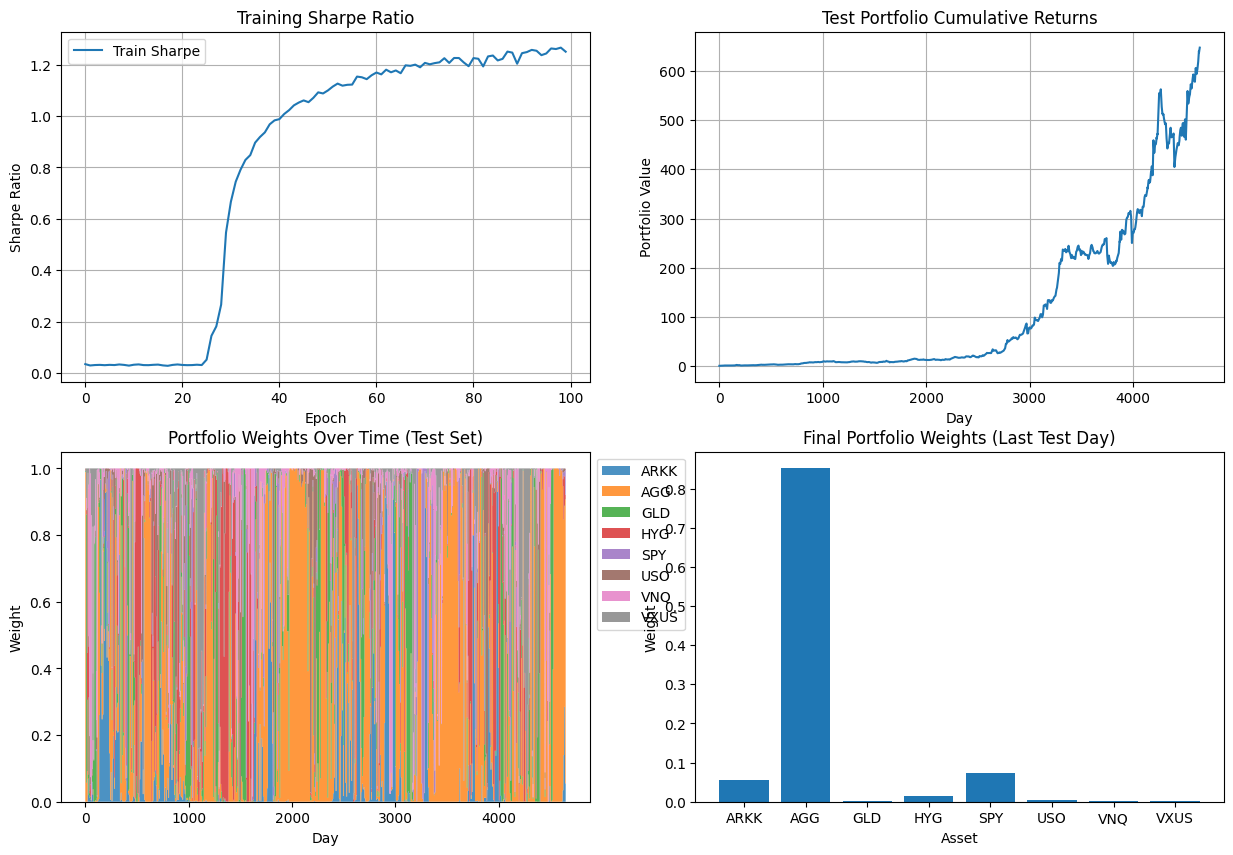

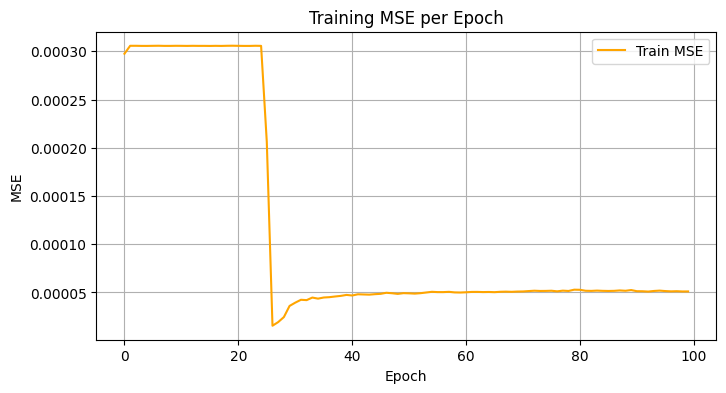

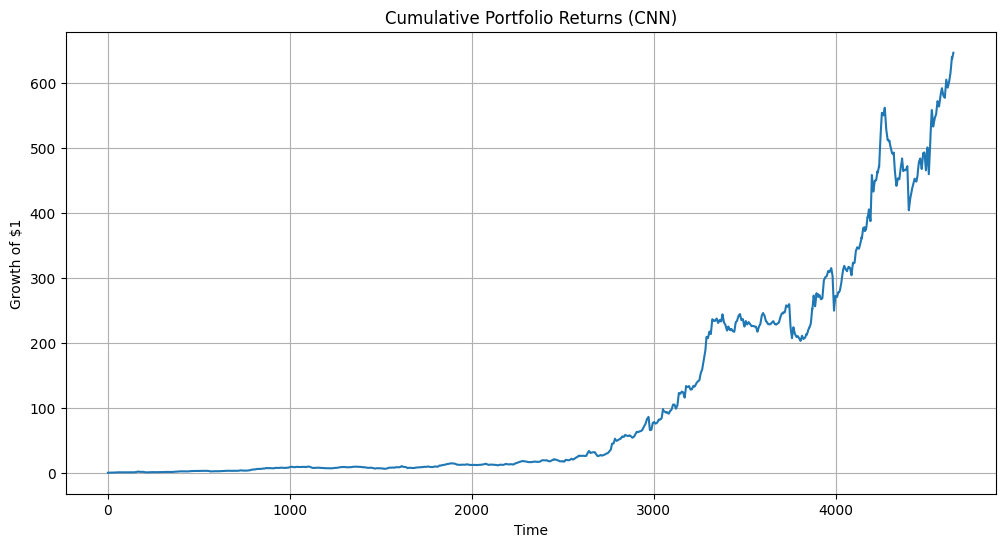

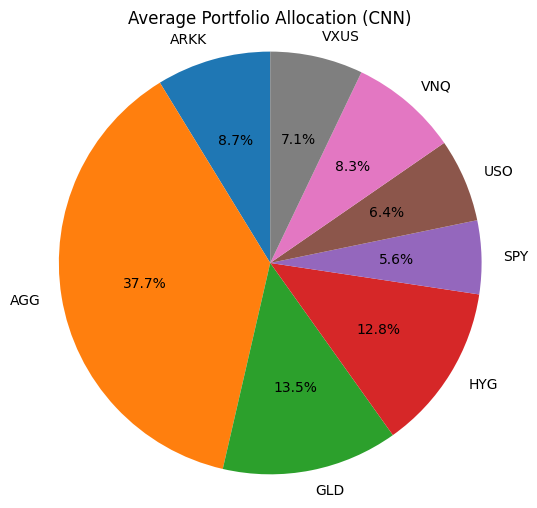

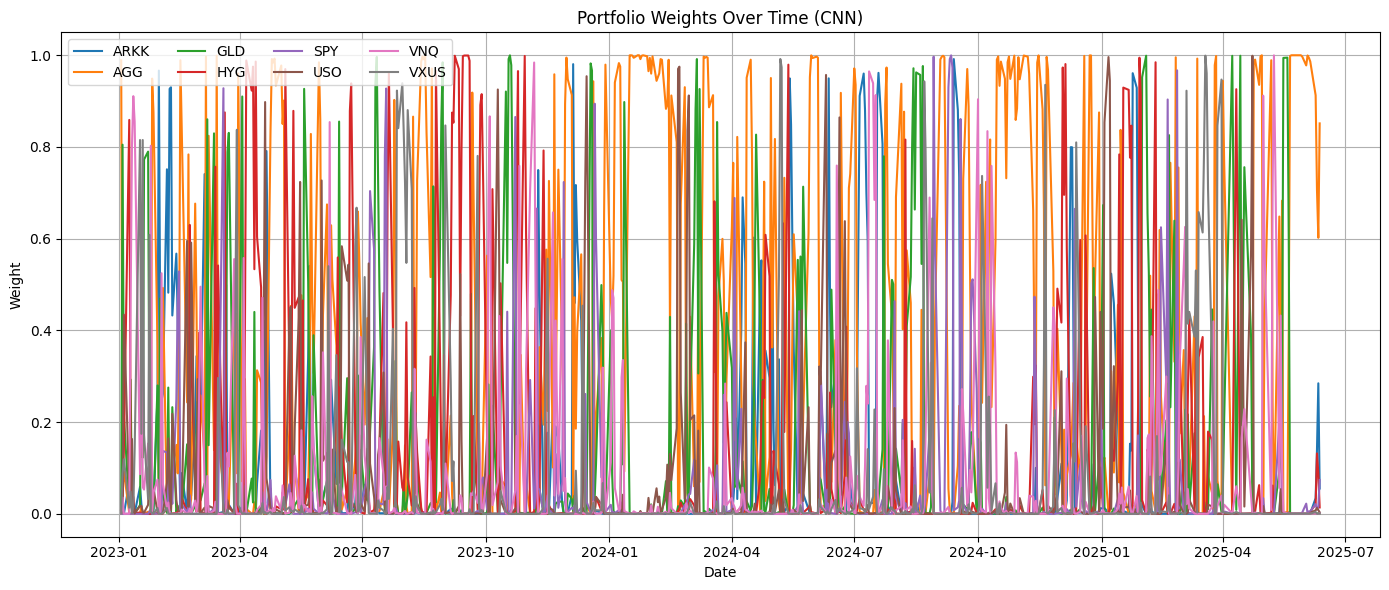

NameError: name 'latest_weights' is not defined

<Figure size 800x400 with 0 Axes>

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- 8. All Visualizations (2x2 grid + others) ---
plt.figure(figsize=(15, 10))

# 1. Training Loss (Sharpe Loss)
plt.subplot(2,2,1)
plt.plot(train_metrics['sharpe'], label='Train Sharpe')
plt.title('Training Sharpe Ratio')
plt.xlabel('Epoch')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.legend()

# 2. Test Portfolio Cumulative Returns
plt.subplot(2,2,2)
plt.plot(test_results['cumulative_returns'])
plt.title('Test Portfolio Cumulative Returns')
plt.xlabel('Day')
plt.ylabel('Portfolio Value')
plt.grid(True)

# 3. Portfolio Weights Over Time (Test Set)
plt.subplot(2,2,3)
weights = np.array(test_results['weights'])
plt.stackplot(range(weights.shape[0]), weights.T, labels=assets, alpha=0.8)
plt.title('Portfolio Weights Over Time (Test Set)')
plt.xlabel('Day')
plt.ylabel('Weight')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 4. Final Portfolio Weights (Last Test Day)
plt.subplot(2,2,4)
plt.bar(assets, weights[-1])
plt.title('Final Portfolio Weights (Last Test Day)')
plt.xlabel('Asset')
plt.ylabel('Weight')

# plt.tight_layout()
# plt.show()

# --- Additional: Training MSE Curve (if desired) ---
plt.figure(figsize=(8, 4))
plt.plot(train_metrics['mse'], label='Train MSE', color='orange')
plt.title("Training MSE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_results['cumulative_returns'])
plt.title("Cumulative Portfolio Returns (CNN)")
plt.xlabel("Time")
plt.ylabel("Growth of $1")
plt.grid(True)
plt.show()

avg_weights = np.nan_to_num(test_results['weights'].mean(axis=0), nan=0.0)
plt.figure(figsize=(6, 6))
plt.pie(avg_weights, labels=assets, autopct='%1.1f%%', startangle=90)
plt.title("Average Portfolio Allocation (CNN)")
plt.axis('equal')
plt.show()

# --- Plot Individual ETF Weights Over Time ---
plt.figure(figsize=(14, 6))
for i, asset in enumerate(assets):
    plt.plot(dates_test, test_results['weights'][:, i], label=asset)
plt.title("Portfolio Weights Over Time (CNN)")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.legend(loc="upper left", ncol=4)
plt.grid(True)
plt.tight_layout()
plt.show()


# ----------------------------
# 3. Bar Chart for Last Day
# ----------------------------
plt.figure(figsize=(8, 4))
latest_weights.plot(kind='bar', color='skyblue')
plt.title("Portfolio Weights - Most Recent Day")
plt.ylabel("Weight")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ----------------------------
# 4. Heatmap of Weights Over Time
# ----------------------------
plt.figure(figsize=(14, 5))
sns.heatmap(weights_df.T, cmap='YlGnBu', cbar_kws={'label': 'Weight'})
plt.title("ETF Portfolio Allocation Over Time (Heatmap)")
plt.xlabel("Date")
plt.ylabel("ETF")
plt.tight_layout()
plt.show()

# Correlation of weight time series
corr_matrix = weights_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation of ETF Allocation Weights Over Time")
plt.show()


In [28]:
print("X_train shape:", X_train.shape)
print("Expected input size:", lookback, n_assets, n_features)


X_train shape: (12083, 480)
Expected input size: 20 8 3


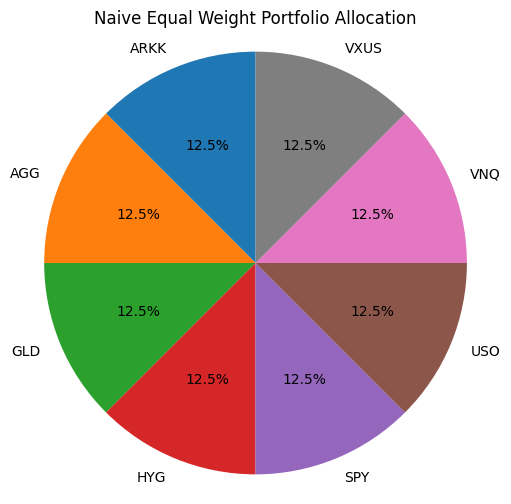

In [66]:
import matplotlib.pyplot as plt

# List of your assets
assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']

# Assign equal weights
n_assets = len(assets)
equal_weights = [1/n_assets] * n_assets

# Plot as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(equal_weights, labels=assets, autopct='%1.1f%%', startangle=90)
plt.title("Naive Equal Weight Portfolio Allocation")
plt.axis('equal')
plt.show()


In [72]:
from graphviz import Digraph

dot = Digraph(format='png')
dot.attr(rankdir='TB', size='8,12', dpi='300', bgcolor='white')

# Blue gradient colors
colors = [
    "#e3f2fd",  # lightest blue
    "#bbdefb",  # lighter blue
    "#90caf9",  # medium blue
    "#42a5f5",  # primary blue
    "#1976d2",  # deep blue
]

# Nodes for each layer with gradient blue
dot.node('A', '''Input Layer
[batch, lookback, 8 assets × 8 features]
(e.g. returns, EMA, RSI, etc.)''',
         shape='box', style='rounded,filled', fillcolor=colors[0], fontsize='16')

dot.node('B', '''Unsqueeze
[batch, 1, lookback, 8 × 8]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

dot.node('C', '''Conv2d Layer
8 filters, kernel=(3,1)
Output: [batch, 8, lookback, 8×8]''',
         shape='box', style='rounded,filled', fillcolor=colors[2], fontsize='16')

dot.node('D', '''ReLU Activation
Non-linearity''',
         shape='box', style='rounded,filled', fillcolor=colors[3], fontsize='16')

dot.node('E', '''Flatten Layer
Output: [batch, flattened_size]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

dot.node('F', '''Fully Connected Layer
Linear: [*, 8 assets]''',
         shape='box', style='rounded,filled', fillcolor=colors[4], fontsize='16')

# Final node in green
dot.node('G', '''Softmax (with Temperature)
Output: Portfolio Weights
[batch, 8 assets] (sum=1)''',
         shape='box', style='rounded,filled', fillcolor='#43a047', fontcolor='white', fontsize='18', fontname='Helvetica')

# Edges
dot.edge('A', 'B', color='#1976D2', penwidth='2')
dot.edge('B', 'C', color='#1976D2', penwidth='2')
dot.edge('C', 'D', color='#1976D2', penwidth='2')
dot.edge('D', 'E', color='#1976D2', penwidth='2')
dot.edge('E', 'F', color='#1976D2', penwidth='2')
dot.edge('F', 'G', color='#43a047', penwidth='2')  # green for the final edge

# Render and display
dot.render('cnn_portfolio_architecture_gradient', view=True)


'cnn_portfolio_architecture_gradient.png'

DMI_minus_14','DMI_plus_14','MACD_Signal','ATR_14','Calmar_Ratio_21','OBV',
                       'Max_Drawdown_21','EMA_10','EMA_50','umich_consumer_sentiment','new_home_sales','housing_starts','baa_yield','industrial_production'